In [1]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/AnatSearchlight')
sys.path.append('/Users/aghavamp/Desktop/Projects/SUITPy')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



we can extract the x,y,z coordinates of the vertices from our reference surface map. Using this we can define an arbitrary patch to average our percent signal changes along this patch. For example average PSC from SPLa to S1 to M1 to PMd. Basically a strip-average or you might call it ROI activity profile.

example, how to get the required info from the anatomical surface file

In [9]:
surfPy_dir = '/Users/aghavamp/Desktop/Projects/surfAnalysisPy/standard_mesh'
surf_path = os.path.abspath(os.path.join(surfPy_dir, f'fs_R', f'fs_LR.32k.R.flat.surf.gii'))

# Load GIFTI surface
gii = nb.load(surf_path)

# Get vertices (XYZ) and faces
# 'pointset' == NIFTI_INTENT_POINTSET (vertex coordinates)
# 'triangle' == NIFTI_INTENT_TRIANGLE (faces)
verts = gii.agg_data('pointset')   # shape: (N, 3); for flat, Z should be 0
faces = gii.agg_data('triangle')   # shape: (T, 3) int

# Split into x,y,z
x = verts[:, 0]
y = verts[:, 1]
z = verts[:, 2]  # all zeros for .flat surfaces
print(verts.shape, faces.shape, x.min(), x.max(), y.min(), y.max())



(32492, 3) (58914, 3) -250.54503 198.46872 -176.6075 163.74083


# left cortex psc profile

32492


/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_97959/2549427292.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


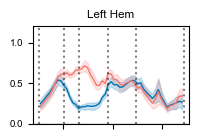

In [4]:
import matplotlib.path as mpath

# DEFINE PATCH:
num_subj = 12
    
    # (119.53, 104),
    # (124.41, 71.85)
# Example: [(x1, y1), (x2, y2), (x3, y3), ...]
polygon_coords = [
    (-25, 41.4), 
    (33.8, 37.2),
    (76.9, 64.2),
    (122.3,73.3),
    (106,110),
    (-44.2, 89.2)
]
patch_path = mpath.Path(polygon_coords)

# Define the axis along which you will create bins
x1, x2 = -25, 122.3
dx = 3
ROIs = ['PMd', 'M1', 'S1', 'SPLa', 'SPLp']
ROI_Xcoords = [-25, 0.8, 16, 45.6, 74, 122.3]

surfPy_dir = '/Users/aghavamp/Desktop/Projects/surfAnalysisPy/standard_mesh'
surf_path = os.path.abspath(os.path.join(surfPy_dir, f'fs_L', f'fs_LR.32k.Lm.flat.surf.gii'))

# Load GIFTI surface
gii = nb.load(surf_path)

# load data:
data = nb.load(os.path.join(analysisDir, 'psc.dscalar.nii'))
beta = data.get_fdata()  # shape: (N, 1) for flat surfaces
scalar_axis = data.header.get_axis(0)  # scalar axis for flat surfaces
row_names = [ax[0] for ax in scalar_axis]  # get row names from scalar axis
idx_lhand = [i for i in range(len(row_names)) if 'lhand' in row_names[i]][0:num_subj]
idx_rhand = [i for i in range(len(row_names)) if 'rhand' in row_names[i]][0:num_subj]
idx_bi = [i for i in range(len(row_names)) if 'bi' in row_names[i]][0:num_subj]

# Get vertices (XYZ)
verts = gii.agg_data('pointset')   # shape: (N, 3); for flat, Z should be 0
x = verts[:, 0]
y = verts[:, 1]
print(len(verts))

# Check which vertices are inside the polygon
points_to_check = np.vstack((x, y)).T
in_strip = patch_path.contains_points(points_to_check)

# You can visualize the selected patch if you want
# fig, ax = plt.subplots(figsize=(3, 2.5))
# plt.scatter(x[in_strip], y[in_strip], s=1)
# plt.show()

bins = np.arange(x1, x2, dx)
centers = 0.5 * (bins[:-1] + bins[1:])

psc_profiles = {'lhand': np.full((num_subj, len(bins) - 1), np.nan),
                'rhand': np.full((num_subj, len(bins) - 1), np.nan),
                'bi': np.full((num_subj, len(bins) - 1), np.nan)}

# profile = np.full((num_subj, len(bins) - 1), np.nan)
# loop on subjects:
for sn in range(num_subj):
    beta_sn = beta[idx_bi[sn], 0:len(verts)] # left hem data

    # Calculate mean PSC in bins for Bimanual:
    for i in range(len(bins) - 1):
        b0, b1 = bins[i], bins[i+1]
        mbin = in_strip & (x >= b0) & (x < b1)
        psc_profiles['bi'][sn, i] = np.nanmean(beta_sn[mbin])  

    # Calculate mean PSC in bins for lhand:
    beta_sn = beta[idx_lhand[sn], 0:len(verts)] # left hem data
    for i in range(len(bins) - 1):
        b0, b1 = bins[i], bins[i+1]
        mbin = in_strip & (x >= b0) & (x < b1)
        psc_profiles['lhand'][sn, i] = np.nanmean(beta_sn[mbin])
        
    # Calculate mean PSC in bins for rhand:
    beta_sn = beta[idx_rhand[sn], 0:len(verts)] # right hem data
    for i in range(len(bins) - 1):
        b0, b1 = bins[i], bins[i+1]
        mbin = in_strip & (x >= b0) & (x < b1)
        psc_profiles['rhand'][sn, i] = np.nanmean(beta_sn[mbin])
        
avg_psc_bi = np.nanmean(psc_profiles['bi'], axis=0)
sem_psc_bi = np.nanstd(psc_profiles['bi'], axis=0) / np.sqrt(num_subj)
avg_psc_lhand = np.nanmean(psc_profiles['lhand'], axis=0)
sem_psc_lhand = np.nanstd(psc_profiles['lhand'], axis=0) / np.sqrt(num_subj)
avg_psc_rhand = np.nanmean(psc_profiles['rhand'], axis=0)
sem_psc_rhand = np.nanstd(psc_profiles['rhand'], axis=0) / np.sqrt(num_subj)

# Plotting the results
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
fig, ax = plt.subplots(figsize=(2, 1.4))
# ax.plot(centers, avg_psc_bi, label='Bimanual', color='k', linewidth=1)
ax.plot(centers, avg_psc_lhand, label='ipsi', color='#0072B2', linewidth=1)
ax.plot(centers, avg_psc_rhand, label='contra', color='#F8766D', linewidth=1)

# ax.fill_between(centers, avg_psc_bi - sem_psc_bi, avg_psc_bi + sem_psc_bi, color='k', alpha=0.2)
ax.fill_between(centers, avg_psc_lhand - sem_psc_lhand, avg_psc_lhand + sem_psc_lhand, color='#0072B2', alpha=0.2)
ax.fill_between(centers, avg_psc_rhand - sem_psc_rhand, avg_psc_rhand + sem_psc_rhand, color='#F8766D', alpha=0.2)
ax.set_title('Left Hem')
for roi_x in ROI_Xcoords:
    ax.axvline(x=roi_x, color='k', linestyle=':', label='_ignore_', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)
# ax.set_xlabel('X Coordinate (mm)')
ax.set_xticklabels([''])
# ax.set_ylabel('Mean PSC')
ax.set_ylim((0, 1.2))
ax.set_yticks(np.arange(0, 1.5, 0.5))
# ax.legend()
plt.tight_layout()
plt.savefig(f'../figures/PSC/PSC_profile_leftHemisphere.pdf', bbox_inches="tight")
plt.show()



# right cortex PSC profile

/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_97959/2830483260.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])


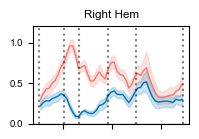

In [5]:
import matplotlib.path as mpath

# DEFINE PATCH:
num_subj = 12

# left hem polygon coords
polygon_coords_left = [
    (-25, 41.4), 
    (33.8, 37.2),
    (76.9, 64.2),
    (122.3,73.3),
    (106,110),
    (-44.2, 89.2)
]

# translate left hem coords to right hem by negating x-coordinates:
polygon_coords_right = [(-x, y) for x, y in polygon_coords_left]
patch_path = mpath.Path(polygon_coords_right)

# Define the axis along which you will create bins
x1, x2 = -122.3, 25
dx = 3
ROIs = ['PMd', 'M1', 'S1', 'SPLa', 'SPLp']
ROI_Xcoords = [25, -0.8, -16, -45.6, -74, -122.3]

surfPy_dir = '/Users/aghavamp/Desktop/Projects/surfAnalysisPy/standard_mesh'
surf_path = os.path.abspath(os.path.join(surfPy_dir, f'fs_R', f'fs_LR.32k.R.flat.surf.gii'))

# Load GIFTI surface
gii = nb.load(surf_path)

# load data:
data = nb.load(os.path.join(analysisDir, 'psc.dscalar.nii'))
beta = data.get_fdata()  # shape: (N, 1) for flat surfaces
scalar_axis = data.header.get_axis(0)  # scalar axis for flat surfaces
row_names = [ax[0] for ax in scalar_axis]  # get row names from scalar axis
idx_lhand = [i for i in range(len(row_names)) if 'lhand' in row_names[i]][0:num_subj]
idx_rhand = [i for i in range(len(row_names)) if 'rhand' in row_names[i]][0:num_subj]
idx_bi = [i for i in range(len(row_names)) if 'bi' in row_names[i]][0:num_subj]

# Get vertices (XYZ)
verts = gii.agg_data('pointset')   # shape: (N, 3); for flat, Z should be 0
x = verts[:, 0]
y = verts[:, 1]

# Check which vertices are inside the polygon
points_to_check = np.vstack((x, y)).T
in_strip = patch_path.contains_points(points_to_check)

bins = np.arange(x1, x2, dx)
centers = 0.5 * (bins[:-1] + bins[1:])

psc_profiles = {'lhand': np.full((num_subj, len(bins) - 1), np.nan),
                'rhand': np.full((num_subj, len(bins) - 1), np.nan),
                'bi': np.full((num_subj, len(bins) - 1), np.nan)}

# profile = np.full((num_subj, len(bins) - 1), np.nan)
# loop on subjects:
for sn in range(num_subj):
    beta_sn = beta[idx_bi[sn], len(verts):] # left hem data

    # Calculate mean PSC in bins for Bimanual:
    for i in range(len(bins) - 1):
        b0, b1 = bins[i], bins[i+1]
        mbin = in_strip & (x >= b0) & (x < b1)
        psc_profiles['bi'][sn, i] = np.nanmean(beta_sn[mbin])  

    # Calculate mean PSC in bins for lhand:
    beta_sn = beta[idx_lhand[sn], len(verts):] # left hem data
    for i in range(len(bins) - 1):
        b0, b1 = bins[i], bins[i+1]
        mbin = in_strip & (x >= b0) & (x < b1)
        psc_profiles['lhand'][sn, i] = np.nanmean(beta_sn[mbin])
        
    # Calculate mean PSC in bins for rhand:
    beta_sn = beta[idx_rhand[sn], len(verts):] # right hem data
    for i in range(len(bins) - 1):
        b0, b1 = bins[i], bins[i+1]
        mbin = in_strip & (x >= b0) & (x < b1)
        psc_profiles['rhand'][sn, i] = np.nanmean(beta_sn[mbin])   

avg_psc_bi = np.nanmean(psc_profiles['bi'], axis=0)
sem_psc_bi = np.nanstd(psc_profiles['bi'], axis=0) / np.sqrt(num_subj)
avg_psc_lhand = np.nanmean(psc_profiles['lhand'], axis=0)
sem_psc_lhand = np.nanstd(psc_profiles['lhand'], axis=0) / np.sqrt(num_subj)
avg_psc_rhand = np.nanmean(psc_profiles['rhand'], axis=0)
sem_psc_rhand = np.nanstd(psc_profiles['rhand'], axis=0) / np.sqrt(num_subj)

# Plotting the results (flipped across x-axis)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
fig, ax = plt.subplots(figsize=(2, 1.4))
centers_flipped = -centers
roi_xcoords_flipped = [-x for x in ROI_Xcoords]

# ax.plot(centers, avg_psc_bi, label='Bimanual', color='k', linewidth=1)
ax.plot(centers_flipped, avg_psc_rhand, label='ipsi', color='#0072B2', linewidth=1)
ax.plot(centers_flipped, avg_psc_lhand, label='contra', color='#F8766D', linewidth=1)#F8766D

# ax.fill_between(centers, avg_psc_bi - sem_psc_bi, avg_psc_bi + sem_psc_bi, color='k', alpha=0.2)
ax.fill_between(centers_flipped, avg_psc_lhand - sem_psc_lhand, avg_psc_lhand + sem_psc_lhand, color='#F8766D', alpha=0.2)
ax.fill_between(centers_flipped, avg_psc_rhand - sem_psc_rhand, avg_psc_rhand + sem_psc_rhand, color='#0072B2', alpha=0.2)

ax.set_title('Right Hem')
for roi_x in roi_xcoords_flipped:
    ax.axvline(x=roi_x, color='k', linestyle=':', label='_ignore_', alpha=0.5)
ax.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)

# ax.set_xlabel('X Coordinate (mm)')
# ax.set_ylabel('Mean PSC')
# ax.legend()
ax.set_xticklabels([''])
ax.set_ylim((0, 1.2))
ax.set_yticks(np.arange(0, 1.5, 0.5))
plt.tight_layout()
plt.savefig(f'../figures/PSC/PSC_profile_rightHemisphere.pdf', bbox_inches="tight")
plt.show()


